<font size="6">MEC301 - Metodos Numéricos</font>
# 1.4 Métodos de Interpolación
<br><br><br><br>
Profesor: Francisco Ramírez Cuevas<br>
Fecha: 29 de Agosto 2022

## Introducción

La siguiente tabla muestra las propiedades del agua en función de la temperatura.

<img src="./images/thermodynamic_properties.png" width="600" align= center>

En ingeniería generalmente debemos utilizar estas tablas. Si quisieramos determinar, por ejemplo, el valor de la densidad a $10\mathrm{^oC}$ necesitaríamos conocer la función $\rho(T)$, ya que el valor no está en la tabla.

¿Cuál es la función más adecuada para representar la densidad?

A diferencia de nuestro problema de ajuste por mínimos cuadrados, en este caso cada valor de la tabla es certero. Es decir, nuestra función debe pasar **estrictamente** por cada valor indicado en la tabla.

Llamamos a esta función, **función de interpolación** y en esa clase revisaremos diferentes métodos para generarla.

## Interpolación Polinomial

Una alternativa, es generar un polinomio de la forma:

\begin{equation*}
f(x) = a_0 + a_1x + a_2x^2 + \cdots + a_nx^n
\end{equation*}

considerando $n+1$ datos, existe solo un polinomio que pasa exáctamente por todos los puntos.

La forma más intuitiva para resolver este problema consiste en formar "$n+1$" ecuaciones considerando la intersección con los $n+1$ datos. Sin embargo este método genera matrices mal condicionadas que son sencibles a errores de redondeo.

Por ejemplo, si queremos determinar el polinomio $f(x) = a_0 + a_1x + a_2x^2$ que pasa por los puntos $\{x_i,y_i\} = \{300,0.616\}$, $\{400,0.616\}$ y $\{500,0.457\}$, llegamos a un sistema de ecuaciones de la forma:

\begin{equation*}
\begin{bmatrix}
 1 & 300 & 300^2 \\
 1 & 400 & 400^2 \\
 1 & 500 & 500^2 \\
\end{bmatrix}
\left[\begin{array}{c} a_0 \\a_1\\a_2\end{array}\right] =
\left[\begin{array}{c} 0.616 \\0.525\\0.457 \end{array}\right]
\end{equation*}

Tenemos que la matriz $A$ está mal condicionada

In [1]:
import numpy as np
A = np.array([[1, 300, 300**2],
              [1, 400, 400**2],
              [1, 500, 500**2]])

print('cond(A)', np.linalg.cond(A))

cond(A) 5893156.794924004


En este capítulo explicaremos métodos alternativos para generar este polinomio de forma más estable.

### Intepolación mediante `polyfit` (ajuste por mínimos cuadrados)
En la clase anterior usamos la función `polyfit` para generar un polinomio por ajuste por mínimos cuadrados. Estrictamente hablando, **regresión lineal no está clasificado como método de interpolación, ya que el polinomio no necesariamente pasa por todos los datos $x_i, y_i$ de la muestra**. Sin embargo, para un polinomio de grado $n$ y una muestra con $n$ datos, `polyfit` entregará un polinomio de interpolación.

Por ejemplo, consideremos el polinomio de ajuste para la muestra:

|$i$ |0 | 1 | 2 | 3 | 4|
|:-:|:-:|:-:|:-:|:-:|:-:|
| $x_i$ |-5 | -2 | 0 | 3 | 5|
| $y_i$ |-2 | -1 | 2 | 2.5 | -1|

Generaremos un polinomio de grado 2 mediante ```polyfit```, considerando dos casos:
1. Todos los datos *x = [-5, -2, 0, 3, 5]*, *y = [-2,  -1, 2, 2.5,-1]*.
2. Solo los datos *x = [-5, 0, 5]*, *y = [-2, 2,-1]*, es decir $\{x_i,y_i\}$ para $i = 0,2,4$.

In [2]:
%%capture showplot
import matplotlib.pyplot as plt
import numpy as np

# Datos de la muestra xi, yi
xi = np.array([-5, -2, 0, 3, 5])
yi = np.array([-2,  -1, 2, 2.5,-1])

x = np.arange(-5, 5, .1) # arreglo en x para graficar

# polinomio grado 2 por ajuste con todos (xi,yi)
ai = np.polyfit(xi,yi,2)
y_fit = np.polyval(ai,x)

# polinomio grado 2 por ajuste con (xi,yi) para i = 0, 2, 4
ai = np.polyfit(xi[[0, 2, 4]],yi[[0, 2, 4]],2)
y_pol = np.polyval(ai,x)

plt.figure(figsize = (9, 6))           # Tamaño de figura
plt.rcParams.update({'font.size': 18}) # Tamaño de fuente

# ploteamos los dos polinomios
plt.plot(x, y_fit, '--k',label='todos los $x_i, y_i$')
plt.plot(x, y_pol, 'b',label='solo $(x_i, y_i)$ para $i = 0,2,4$')
# ploteamos xi, yi
plt.plot(xi, yi, 'ro',label='datos $(x_i, y_i)$')

plt.title('Polinomio grado 2 por mínimos cuadrados')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend(frameon=False)
plt.show()

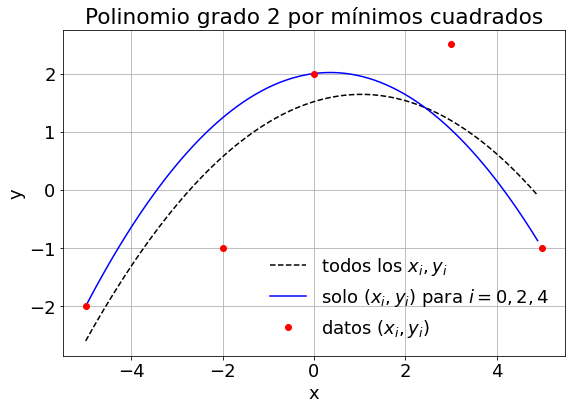

In [3]:
showplot()

Notar como **la curva azul pasa exáctamente por los puntos $\{x_i, y_i\} = \{-5, -2\}$, $\{0, 2\}$ y $\{5, 1\}$**

### Polinomios de interpolación de Newton
Un polinomio de interpolación de Newton de grado $n$ está definido por:

\begin{equation*}
N(x) = a_0 + a_1(x-x_0) + a_2(x-x_0)(x-x_1) + \dots + a_n(x-x_0)(x-x_1)\dots(x-x_n),
\end{equation*}

o bien, en su forma compacta:

\begin{equation}
N(x) = \sum_{i=0}^{n}{a_i\prod_{j=0}^{i-1}(x-x_j)}
\end{equation}

La forma de este polinómio asegura que: $N(x_i) = y_i$ para $i= 0,1,...,n$, donde $x_i, y_i$ son las coordenadas de los datos de la muestra en el plano $x, y$.

Los coeficientes $a_i$ se obtienen a partir de una fórmula definida en función de los datos $x_i$ y $N(x_i) = y_i$. Por ejemplo, a partir de $N(x_0) = y_0$ determinamos:

\begin{equation*}
a_0 = y_0,
\end{equation*}

luego, para $N(x_1) = y_1$, tenemos $N(x_1) = a_0 + a_1(x_1-x_0) = y_1$, donde deducimos:

\begin{equation*}
a_1 = \frac{y_1 - y_0}{x_1 - x_0}
\end{equation*}

para $(x_2, y_2)$:

\begin{equation*}
a_2 = \frac{\frac{y_2 - y_1}{x_2 - x_1} - \frac{y_1 - y_0}{x_1 - x_0}}{x_2 - x_0}
\end{equation*}

para $(x_3, y_3)$:

\begin{equation*}
a_3 = \frac{\frac{\frac{y_3-y_2}{x_3-x_2} - \frac{y_2 - y_1}{x_2-x_1}}{x_3 - x_1} - \frac{\frac{y_2-y_1}{x_2-x_1}-\frac{y_1 - y_0}{x_1 - x_0}}{x_2-x_0}}{x_3 - x_0}
\end{equation*}

En forma generalizada, decimos que $a_k = f[x_k, x_{k-1}, \dots, x_{1}, x_0]$, donde:

\begin{equation*}
f[x_k, x_{k-1}, \dots, x_{1}, x_0] = \frac{f[x_k, x_{k-1}, \dots, x_{2}, x_2] - f[x_{k-1}, x_{k-2}, \dots, x_{1}, x_0]}{x_k-x_0},
\end{equation*}

esta operación se define como **diferencias divididas**.

por ejemplo:

\begin{align*}
f[x_1, x_0] &= \frac{y_1 - y_0}{x_1 - x_0} \\[10pt]
f[x_2, x_1, x_0] &= \frac{\frac{y_2 - y_1}{x_2 - x_1} - \frac{y_1 - y_0}{x_1 - x_0}}{x_2 - x_0} = \frac{f[x_2,x_1] - f[x_1,x_0]}{x_2-x_0}
\end{align*}

Para determinar las diferencias divididas utilizamos un método recursivo que podemos resumir mediante la siguiente tabla:
<img src="./images/newton_recursion.png" width="600" align= center>

El algoritmo almacena estos valores en una matriz triangular superior, donde la primera fila corresponde al valor de los coeficientes

**No existe una función formal en python para determinar los polinomios de Newton**. Sin embargo su implementación en código es sencilla.

In [4]:
import numpy as np

def divided_diff(x, y):
    '''
    función para generar los coeficientes del
    polinomio de Newton de orden "n"
    '''
    n = len(y)
    coef = np.zeros([n, n])
    coef[:,0] = y # primera columna yi
    
    for j in range(1,n):
        for i in range(n-j):
            coef[i][j] = (coef[i+1][j-1] - coef[i][j-1]) /  \
                                  (x[i+j]-x[i])
            
    return coef[0, :] # retornamos la primera fila

In [5]:
def newton_poly(coef, x_data, x):
    '''
    evalúa el polinomio de newton en x con los coeficientes
    de divided_diff
    '''
    n = len(x_data) - 1 
    p = coef[n]
    for k in range(1,n+1):
        p = coef[n-k] + (x -x_data[n-k])*p
    return p

Probamos nuestra función para *$x_i$ = [-5, -1, 0, 2]*, *$y_i$ = [-2, 6, 1, 3]*. 

In [6]:
%%capture showplot
import matplotlib.pyplot as plt

# Datos de la muestra xi, yi
xi = np.array([-5, -1, 0, 2])
yi = np.array([-2,  6, 1, 3])

# Determinamos coeficientes por diferencias divididas
ai = divided_diff(xi, yi)

# Generamos un arreglo en x para plotear
x = np.arange(-5, 2.1, .1)

# Generar el polinomio de Newton usando "ai"
y = newton_poly(ai, xi, x)

plt.figure(figsize = (9, 6))          # Tamaño de figura
plt.rcParams.update({'font.size': 18}) # Tamaño de fuente

# ploteamos el polinomio de Lagrange
plt.plot(x, y, 'k',label='$N(x)$')

# ploteamos los xi, yi
plt.plot(xi, yi, 'ro',label='datos $x_i, y_i$')

plt.title('Interpolación de Newton')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend(frameon=False)
plt.show()

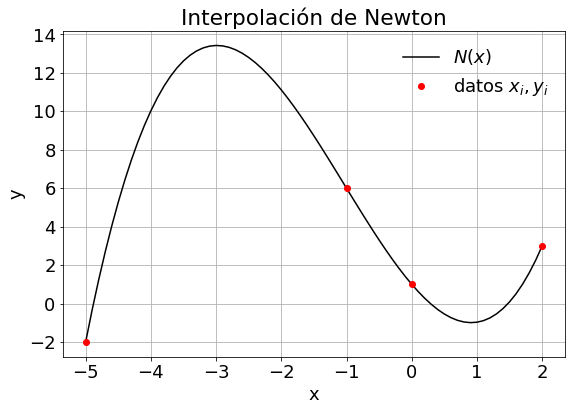

In [7]:
showplot()

### Polinomios de interpolación de Lagrange
La interpolación por polinomios de Lagrange consiste en aproximar una serie de datos mediante un polinomio $L(x_i)$, tal que:

\begin{equation}
L(x) = \sum_{i = 0}^n y_i P_i(x),
\end{equation}

donde $P_i(x)$, son los polinomios de Lagrange, definidos por:
\begin{equation}
P_i(x) = \prod_{j = 1, j\ne i}^n\frac{x - x_j}{x_i - x_j}.
\end{equation}

Estos polinomios tienen la propiedad que $P_i(x_j) = 1$ cuando $i = j$ y $P_i(x_j) = 0$ cuando $i \ne j$. Así, al igual que la interpolación por polinomios de Newton, la interpolación de Lagrange asegura que $L(x_i) = y_i$ para cada dato de la muestra.

Por ejemplo, para el set de datos *$x_i$ = [0, 1, 2]*, *$y_i$ = [1, 3, 2]*, podemos definir tres polinomios de Lagrange:

\begin{eqnarray*}
P_0(x) &=& \frac{(x - x_1)(x - x_2)}{(x_0-x_1)(x_0-x_2)} = \frac{(x - 1)(x - 2)}{(0-1)(0-2)} = \frac{1}{2}(x^2 - 3x + 2),\\[10pt]
P_1(x) &=& \frac{(x - x_0)(x - x_2)}{(x_1-x_0)(x_1-x_2)} = \frac{(x - 0)(x - 2)}{(1-0)(1-2)} = -x^2 + 2x,\\[10pt]
P_2(x) &=& \frac{(x - x_0)(x - x_1)}{(x_2-x_0)(x_2-x_1)} = \frac{(x - 0)(x - 1)}{(2-0)(2-1)} = \frac{1}{2}(x^2 - x).
\end{eqnarray*}

Graficamos los polinomios de Lagrange $P_0(x)$, $P_1(x)$ y $P_2(x)$:

In [8]:
%%capture showfig
import numpy as np
import matplotlib.pyplot as plt

# Polinomios de Lagrange
P0 = lambda x: 1/2*(x**2 - 3*x + 2)
P1 = lambda x: -x**2 + 2*x
P2 = lambda x: 1/2*(x**2 - x)

# variable para plotear
x = np.linspace(-0.5,2.5,100)

fig = plt.figure(figsize = (9,7))      # tamaño de figura
plt.rcParams.update({'font.size': 18}) # tamaño de fuente

# ploteamos las curvas de cada polinomio
plt.plot(x, P0(xp), 'b', label = '$P_0(x)$')
plt.plot(x, P1(xp), 'r', label = '$P_1(x)$')
plt.plot(x, P2(xp), 'g', label = '$P_2(x)$')

plt.title('Polinomios de Lagrange')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend(frameon=False)
plt.show()

NameError: name 'xp' is not defined

In [9]:
showfig()

<Figure size 648x504 with 0 Axes>

En python los polinomios de Lagrange están implementados en la función ```lagrange``` de la librería```scipy.interpolate``` (ver documentación [acá](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.lagrange.html))

In [10]:
%%capture showplot
from scipy.interpolate import lagrange
xi = [0, 1, 2]
yi = [1, 3, 2]

# Genera una función en base a interpolación de Lagrange
L = lagrange(xi, yi)

# variable para plotear
x = np.linspace(-0.5,2.5,100)

plt.figure(figsize = (9, 6))           # Tamaño de figura
plt.rcParams.update({'font.size': 18}) # Tamaño de fuente

# ploteamos el polinomio de Lagrange
plt.plot(x, L(x), 'k',label='$L(x)$')

# ploteamos los xi, yi
plt.plot(xi, yi, 'ro',label='datos $x_i, y_i$')

plt.title('Interpolación de Lagrange')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend(frameon=False)
plt.show()

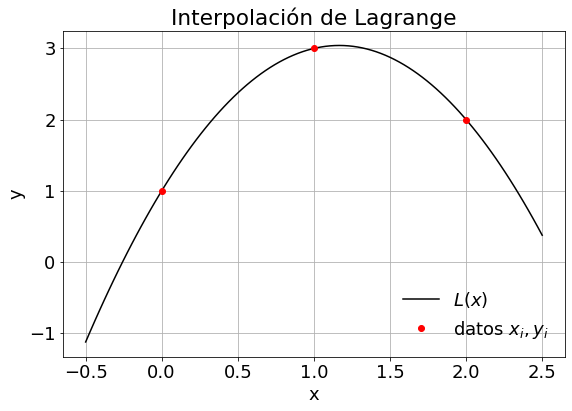

In [11]:
showplot()

### Problemas de oscilación
Un problema de los polinomios de interpolación es que sufren problemas de oscilación a medida que aumenta el número de datos en la muestra.

Este problema se conoce como el **fenómeno de Runge**, en referencia a Carl Runge, quién en 1901 demostró el mal condicionamiento de los polinomios de interpolación cuando se analizaba la siguiente función:

\begin{equation*}
f(x)=\frac{1}{1 + 25x^2}
\end{equation*}

Esta función se conoce como **función de Runge**

Analicemos este problema considerando el dominio $x\in\left[-1,1\right]$. Utilizando polinomios de Lagrange, generaremos un polinomio de interpolación, $L_5(x)$, con 5 datos igualmente espaciados; y un polinomio, $L_7(x)$, 7 datos igualmente espaciados.

In [12]:
import numpy as np
from scipy.interpolate import lagrange 

# generamos la funcion Runge
f = lambda x: 1/(1+25*x**2)

# Polinomio con 5 datos igualmente espaciados
xi5 = np.linspace(-1,1,5)    # xi
yi5 = f(xi5)                 # yi 
L5 = lagrange(xi5,yi5) # polinomio de Lagrange

# Polinomio con 7 datos igualmente espaciados
xi7 = np.linspace(-1,1,7)    # xi
yi7 = f(xi7)                 # yi 
L7 = lagrange(xi7,yi7) # polinomio de Lagrange

Graficamos el resultado

In [13]:
%%capture showplot
import matplotlib.pyplot as plt
plt.figure(figsize = (9, 6))           # Tamaño de figura
plt.rcParams.update({'font.size': 18}) # Tamaño de fuente

# arreglo para plotear
x = np.linspace(-1,1,100)

# ploteamos la función de Runge
plt.plot(x,f(x),'--k', label='Runge')

# ploteamos los polinomios de Lagrange
plt.plot(x, L5(x), 'r',label='$L_5(x)$')
plt.plot(x, L7(x), 'b',label='$L_7(x)$')

# ploteamos los xi, yi
plt.plot(xi5, yi5, 'ro',label='_$x_i, y_i$ para $L_5(x)$')
plt.plot(xi7, yi7, 'bo',label='_$x_i, y_i$ para $L_76(x)$')

plt.title('Interpolación de Lagrange')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend(frameon=False)
plt.show()

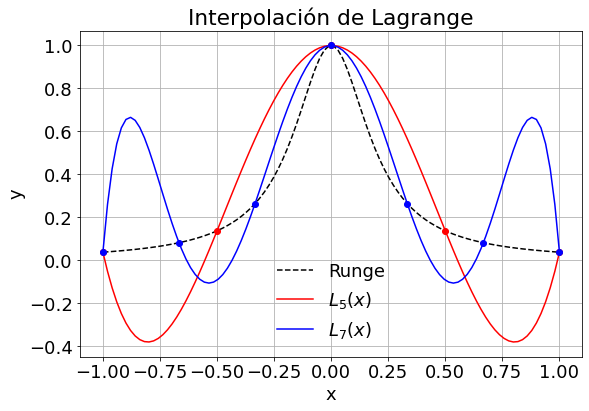

In [14]:
showplot()

## Interpolación por tramos
Una alternativa para evitar los problemas de oscilación de los polinomios de interpolación, es usar polinomios de menor orden e interpolar por tramos.

En este caso, para un set de $n+1$ datos $\{x_i, y_i\}$, con $i = 0,1,...,n$, el método de interpolación por tramos consiste en contruir $n$ polinomios de interpolación para los $n$ intervalos interiores.

<img src="./images/piecewise_interpolation.png" width="500" align= center>

### Interpolación lineal (*spline* linear)
El modelo más simple consiste en interpolar el valor $\{x, y\}$ entre dos puntos $\{x_i, y_i\}$ y $\{x_{i+1}, y_{i+1}\}$ mediante una recta. 

El **método de interpolación lineal consiste en construir $n$ rectas $\hat{y}_i(x)$. Las rectas $\hat{y}_i(x)$ tienen la forma:

\begin{equation*}
\hat{y}_i(x) = y_i + \frac{y_{i+1} - y_{i}}{x_{i+1} - x_{i}}(x - x_{i}),\quad\quad x\in\left[x_i, x_{i+1}\right]
\end{equation*}

En python ```interp1d``` de la librería ```scipy.interpolate``` permite generar una **función** en base interpolación lineal (para documentación ver [acá](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html)).

Por ejemplo, si buscamos el valor de $x_0 = 1.5$ mediante interpolación lineal con los datos *$x_i$ = [0, 1, 2]*, *$y_i$ = [1, 3, 2]*

In [15]:
from scipy.interpolate import interp1d

xi = [0, 1, 2]
yi = [1, 3, 2]

y = interp1d(xi, yi) # Genera una función 
y0 = y(1.5)          # Evaluamos la función en x0 = 1.5
print('y0 = y(x0 = 1.5) =',y0)

y0 = y(x0 = 1.5) = 2.5


Igualmente, podemos usar la función generada por ```interp1d``` para interpolar un arreglo de valores de "x" (por ejemplo, para graficar la función).

In [16]:
%%capture showplot
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (9, 6))           # Tamaño de figura
plt.rcParams.update({'font.size': 18}) # Tamaño de fuente

# variable para graficar
x = np.linspace(0,2.0,100)

plt.plot(x, y(x), '-b', label='$y(x)$')            # graficamos la función
plt.plot(xi, yi, 'ob')                             # graficamos los xi, yi 
plt.plot(1.5, y_hat, 'or', label='$y(x_0 = 1.5)$') # graficamos y(1.5)

plt.title('Interpolación lineal (interp1d de scipy)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend(frameon=False)
plt.show()

NameError: name 'y_hat' is not defined

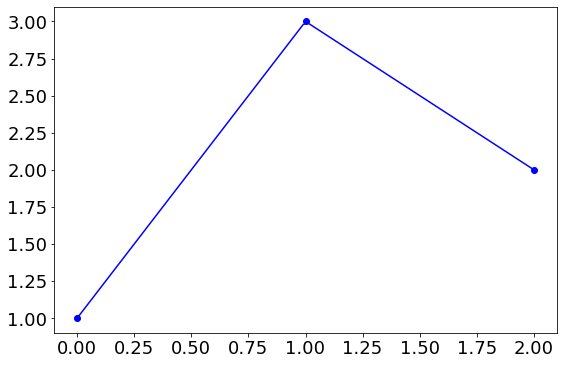

In [17]:
showplot()

Alternativamente, podemos usar```numpy.interp``` que entrega el **valor interpolado $y(x_0) = y_0$**, a partir de los datos $x_i$, $y_i$, y el valor a interpolar $x_0$ (ver documentación [acá](https://numpy.org/doc/stable/reference/generated/numpy.interp.html)). 

In [18]:
import numpy as np

xi = [0, 1, 2]
yi = [1, 3, 2]

x0 = 1.5
y0 = np.interp(x0, xi, yi) # interpolamos y(x) en x0 = 1.5
print('y0 = y(x0 = 1.5) =',y0)

y0 = y(x0 = 1.5) = 2.5


En este caso, para graficar, usamos ```numpy.interp``` para generar un arreglo $y$ de valores interpolados en base a un arreglo $x$.

In [19]:
%%capture showplot
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (9, 6))           # Tamaño de figura
plt.rcParams.update({'font.size': 18}) # Tamaño de fuente

# variable para graficar
x = np.linspace(0,2.0,100)
y = np.interp(x,xi,yi)

plt.plot(x, y, '-b', label='$y(x)$')               # graficamos la función
plt.plot(xi, yi, 'ob')                             # graficamos los xi, yi 
plt.plot(1.5, y_hat, 'or', label='$y(x_0 = 1.5)$') # graficamos y(1.5)

plt.title('Interpolación lineal (interp de numpy)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend(frameon=False)
plt.show()

NameError: name 'y_hat' is not defined

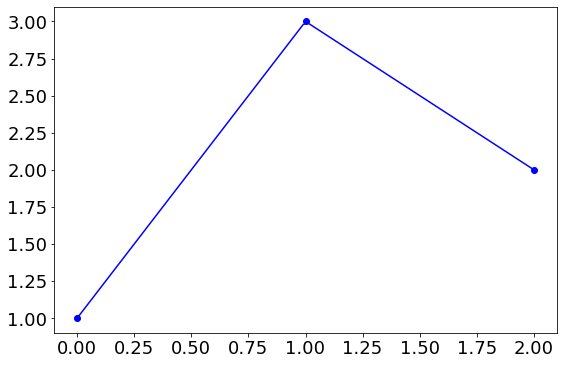

In [20]:
showplot()

Notar que ```interp1d``` de la librería ```scipy.interpolate``` requiere 2 argumentos, mientras que ```numpy.interp``` requiere 3:
```python 
from scipy.interpolate import interp1d
y = interp1d(xi,yi) # Genera una función y(x)
...
from numpy import interp
y = interp(x,xi,yi) # Genera un arreglo en base a "x"
```

Por defecto, los métodos de interpolación lineal no están diseñados para extrapolar:
- La función ```interp1d``` de ```scipy.interpolate``` arrojará un error si el valor $x$ está fuera de los límites de interpolación. 

- Por otro lado, ```interp``` de ```numpy``` entregará un valor ```NaN```.

### Interpolación *spline* cúbico
El *sline* cúbico consiste en generar una función de interpolación basado en una serie de polinomios cúbicos $S_i(x) = a_i x^3 + b_i x^2 + c_i x + d_i$, cada uno definido en el tramo $x\in\left[x_i, x_{i+1}\right]$

Para encontrar la función de interpolación debemos determinar los coecientes $a_i, b_i, c_i, d_i$ de cada $S_i(x)$.

Considerando una serie de datos $\{x_i, y_i\}$, con $i = 0,1,...,n$, el *spline* cúbico necesita $n$ polinomios $S_i(x)$, lo que nos da un total de $4n$ incognitas. Por lo tanto, necesitamos $4n$ ecuaciones linealmente independientes.

Primero, cada polinomio $S_i(x)$ debe intersectar los valores extremos del domino en el que está definido. En otras palabras:

\begin{eqnarray*}
S_i(x_{i-1}) &=& y_{i-1},\quad &i& = 1,\ldots,n,\\
S_i(x_i) &=& y_i,\quad &i& = 1,\ldots,n,
\end{eqnarray*}

esto nos da un total de $2n$ ecuaciones linealmente independientes

La segunda condición viene de la unión entre los polinomios. Para asegurar una unión suave entre cada tramo, imponemos las condiciones:

\begin{eqnarray*}
S^{\prime}_i(x_{i}) &=& S^{\prime}_{i+1}(x_{i}),\quad i = 1,\ldots,n-1,\\
S''_i(x_{i}) &=& S''_{i+1}(x_{i}),\quad i = 1,\ldots,n-1,
\end{eqnarray*}

lo que nos da un total de $2(n - 1)$ ecuaciones linealmente independientes.

Las últimas dos ecuaciones se determinan por las condiciones de borde en los extremos $y(x_0)$,  $y(x_n)$. Tenemos distintas alternativas:

- ***Not a knot***. Imponemos una condición para la tercera derivada en los extremos, de manera que $S_1'''(x_1) = S_2'''(x_1)$ y $S_{n-1}'''(x_{n-1}) = S_n'''(x_{n-1})$

- ***Clamped***. La primera derivada en los extremos, $S_1'(x_0) = S_n'(x_n) = 0$

- ***Natural***. La segunda derivada en los extremos, $S_1''(x_0) = S_n''(x_n) = 0$

- ***Periodic***. Se usume una función periódica, de manera que $S_1'(x_0) = S_n'(x_n)$, y $S_1''(x_0) = S_n''(x_n)$. **Solo válida para funciones periodicas**, es decir cuando $y(x_0) = y(x_n)$.

En python, interpolación cúbica está implementada a través de la función ```CubicSpline``` de la librería ```scipy.interpolate``` (para documentación ver [acá](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html)).

```CubicSpline``` genera una **función de interpolación** a partir de la muestra $x_i, y_i$
```python 
from scipy.interpolate import CubicSpline
y = CubicSpline(xi,yi) # Genera una función y(x)
```

Podemos controlar las condiciones de borde mediante un tercer argumento ```bc_type```:
```python 
from scipy.interpolate import CubicSpline
y = CubicSpline(xi,yi,bc_type='not-a-knot') # Condición de borde not a knot

y = CubicSpline(xi,yi,bc_type='periodic')   # Condición de borde periodica

y = CubicSpline(xi,yi,bc_type='clamped')    # Condición de borde "clamped"

y = CubicSpline(xi,yi,bc_type='natural')    # Condición de borde"natural"
```

También podemos usar ```bc_type``` para especificar el valor de las derivadas en los extremos:
```python 
from scipy.interpolate import CubicSpline
# Primera derivada = 0.5 en los extremos"
y = CubicSpline(xi,yi,bc_type=((1, 0.5), (1, 0.5))) 

# Segunda derivada = 0.5 en los extremos"
y = CubicSpline(xi,yi,bc_type=((2, 0.5), (2, 0.5)) ) 
```

Particularmente, la instrucción: 
- ```bc_type=((1, 0.0), (1, 0.0))``` es equivalente a ```clamped```, y
- ```bc_type=((2, 0.0), (2, 0.0))``` es equivalente a ```natural```.

Por defecto, ```CubicSpline```asume ```bc_type='not-a-knot'```

Analicemos el comportamiento de las condiciones de borde ```not-a-knot```, ```clamped```y ```spline``` en la interpolación spline de los datos *$x_i$ = [3, 5, 7, 9]*, *$y_i$ = [2.5, 1.5, 2.0, 1.8]*

In [21]:
from scipy.interpolate import CubicSpline
import numpy as np

xi = np.array([  3,   5,   7,   9])
yi = np.array([2.5, 1.5, 2.0, 1.8])

# Generamos 3 funciones de interpolación "spline" con distintas condiciones de borde
y_1 = CubicSpline(xi,yi,bc_type='not-a-knot')
y_2 = CubicSpline(xi,yi,bc_type='clamped')
y_3 = CubicSpline(xi,yi,bc_type='natural')

In [22]:
%%capture showplot

import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (9, 7))           # Tamaño de figura
plt.rcParams.update({'font.size': 18}) # Tamaño de fuente

x = np.linspace(2,10,100) # variable para graficarS

plt.plot(xi, yi, 'ok')                         # graficamos los xi, yi
plt.plot(x, y_1(x), '-b', label='not-a-knot')  # graficamos la función
plt.plot(x, y_2(x), '-r', label='clamped')     # graficamos la función
plt.plot(x, y_3(x), '-g', label='natural')     # graficamos la función

plt.title('Interpolación spline')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend(frameon=False)
plt.show()

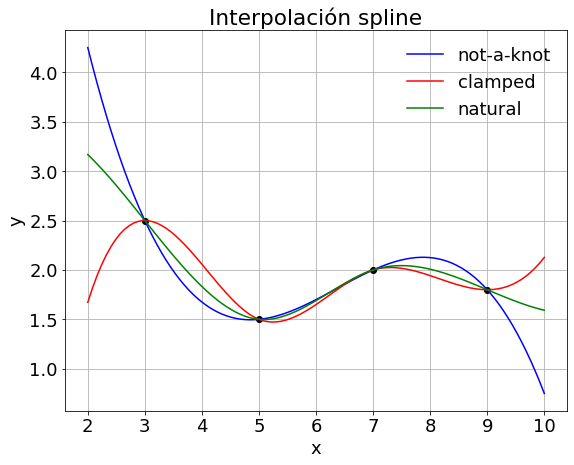

In [23]:
showplot()

Por defecto, ```CubicSpline``` extrapola los valores fuera de los valores extremos. Podemos suprimir la extrapolación mediante la instrucción ```extrapolate=False```. En este caso, la función entregará ```NaN``` para los valores extrapolados.

In [24]:
%%capture showplot
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import numpy as np

xi = np.array([  3,   5,   7,   9])
yi = np.array([2.5, 1.5, 2.0, 1.8])

# spline "not a knot" sin extrapolación
y_1 = CubicSpline(xi,yi,extrapolate=False)

plt.figure(figsize = (9, 6))           # Tamaño de figura
plt.rcParams.update({'font.size': 18}) # Tamaño de fuente

x = np.linspace(2,10,100) # arreglo para graficar

plt.plot(xi, yi, 'ok')     # graficamos los xi, yi
plt.plot(x, y_1(x), '-b')  # graficamos la función

plt.title('Interpolación spline')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

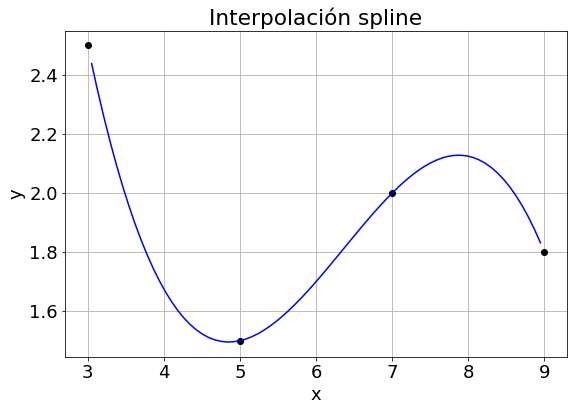

In [25]:
showplot()

```CubicSpline``` además nos permite determinar las derivadas de la función de interpolación. Para esto, debemos incluir un índice en el segundo argumento de la función generada:
```python
from scipy.interpolate import CubicSpline
y = CubicSpline(xi,yi) # Generamos la función de interpolación

# Derivadas
y(x,1) # Primera derivada
y(x,2) # Segunda derivada
y(x,3) # Tercera derivada
```

Debido a que ```CubicSpline``` está basada en un polinomio de interpolación cúbico, **solo admite hasta la tercera derivada**.

In [26]:
%%capture showplot
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import numpy as np

xi = np.linspace(-2*np.pi,2*np.pi,20)
yi = np.sin(xi)

# spline "not a knot"
y_1 = CubicSpline(xi,yi)

plt.figure(figsize = (9, 6))           # Tamaño de figura
plt.rcParams.update({'font.size': 18}) # Tamaño de fuente

x = np.linspace(-2*np.pi,2*np.pi,100) # arreglo para graficar

plt.plot(x, y_1(x), '--k',label=r"$y(x)$")      # graficamos la función
plt.plot(x, y_1(x,1), '-b',label=r"$y'(x)$")   # primera derivada
plt.plot(x, y_1(x,2), '-r',label=r"$y''(x)$")  # segunda derivada
plt.plot(x, y_1(x,3), '-g',label=r"$y'''(x)$") # segunda derivada

plt.title('Derivadas interpolación spline')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-2,2)
plt.grid()
plt.legend()
plt.show()

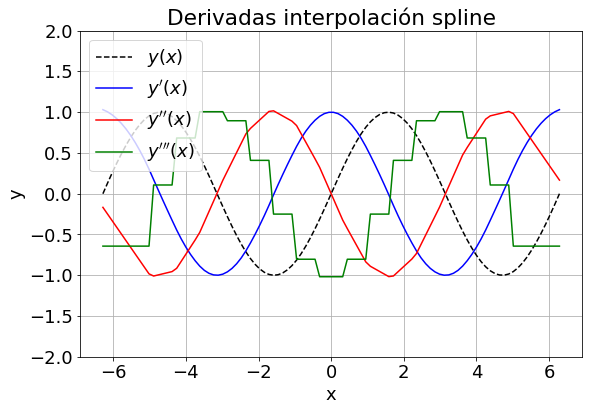

In [27]:
showplot()

## Interpolación multidimensional
Los métodos de interpolación por tramos revisados anteriormente pueden ser extendidos para problemas multidimensionales. Por ejemplo, en el caso 2D, el problema consiste en determinar un valor $z= f(x,y)$, interpolado entre los valores extremos $f(x_1,y_1)$, $f(x_1,y_2)$, $f(x_2,y_1)$ y $f(x_2,y_2)$.

<img src="./images/2dinterpolation.png" width="550" align= center>

### Interpolación 2D
Para interpolacion 2D, la librería ```scipy.interpolate``` posee la funcion ```interp2d``` (para documentación ver [acá](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html)). Esta función retorna una **función** $z = f(x,y)$. 

Para los inputs, ```interp2d``` requiere, al menos, tres argumentos ```(x, y, z)```, donde: 
- ```x``` e ```y``` corresponden a los valores $x_i$ y $y_j$ en formato **arreglo 1D**, o **cuadrídula 2D** generada por ```meshgrid``` 
- ```z``` corresponde a los valores $z_{ij}$ en formato de **cuadrídula 2D**. 

Mediante la intrucción opcional ```kind``` podemos especificar el tipo de polinomio de interpolación. Usamos ```'linear'``` para interpolación linear y ```'cubic'``` para interpolación cúbica. Por defecto, ```kind='linear'```

En el siguiente ejemplo, usamos ```interp2d``` para interpolar una serie de datos $x_i\in\left[-5,5\right]$ y $y_j\in\left[-5,5\right]$, igualmente espaciados con $\Delta x = \Delta y = 0.25$. El valor de $z_{ij}$ es generado a partir de la función $z=\sin\left(x^2+y^2\right)$

In [28]:
from scipy.interpolate import interp2d

# xi, y yj en formato arreglo 1D
xi = np.arange(-5, 5, 0.25)
yj = np.arange(-5, 5, 0.25)

# Cuadrícula 2D generada por meshgrid
xxi, yyj = np.meshgrid(xi, yj)

# generamos una cuadrícula 2D para zij a partir de la función sin(x^2 + y^2)
zij = np.sin(xxi**2+yyj**2)

# Función de interpolación
f = interp2d(xi, yj, zij, kind='cubic')

print('Función de interpolación')
print('z(x=0.15, y=2.45) = ', f(0.15,2.45))

Función de interpolación
z(x=0.15, y=2.45) =  [-0.25105047]


### Interpolación en 3 o más dimensiones
Para interpolación con más de 2 dimensiones, ```scipy.interpolate``` cuenta con la función ```interpn```. 

La discusión respecto a esta función está fuera de los alcances del curso. Sin embargo, puede encontrar más información en la [documentación oficial](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interpn.html).

## Referencias
- Kong Q., Siauw T., Bayen A. M. **Chapter 16: Interpolation** in *[Python Programming and Numerical Methods – A Guide for Engineers and Scientists](https://pythonnumericalmethods.berkeley.edu/notebooks/chapter17.00-Interpolation.html)*, 1st Ed., Academic Press, 2021

- Chapra S., Canale R. **Capítulo 18: Interpolación** en *Métodos Numéricos para Ingenieros*, 6ta Ed., McGraw Hill, 2011